# Deconvolve simulated data with linear functions, vary number of samples

In [1]:
import torch
from ternadecov.simulator import *
from ternadecov.time_deconv import *
from ternadecov.evaluation import *
import matplotlib.pyplot as plt

# Configure

In [2]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

# Load data

In [3]:
bulk_anndata_path = "/home/nbarkas/disk1/work/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk1/work/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [4]:
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

# Simulate data

In [5]:
ebov_sc_dataset = SingleCellDataset(sc_anndata, sc_celltype_col="Subclustering_reduced", dtype_np=dtype_np, dtype = dtype, device=device)

In [6]:
# trajectory generating function
trajectory_type = 'periodic'
n_sample_range = list(range(100,1000,100)) 
n_sample_range

[100, 200, 300, 400, 500, 600, 700, 800, 900]

In [7]:
# Use a single trajectory for all iterations
trajectory_coef = sample_trajectories(
    type = trajectory_type,
    num_cell_types = ebov_sc_dataset.w_hat_gc.shape[1]
)

In [11]:
n_iters = 3_000

n_samples = []
l1_error_norm = []
fit_time = []

for n in n_sample_range:
    eval_result = evaluate_with_trajectory(
        sc_dataset = ebov_sc_dataset, 
        n_samples = n, 
        trajectory_type = trajectory_type, 
        trajectory_coef = trajectory_coef,
        n_iters = n_iters,
        dtype_np = dtype_np,
        dtype = dtype,
        device = device,
        #deconvolution_params = {'polynomial_degree': 3, 'basis_functions': 'polynomial'}
        deconvolution_params = {'trajectory_model_type': 'gp'},
    )
    
    n_samples.append(eval_result['n_samples'])
    l1_error_norm.append(eval_result['l1_error_norm'])
    fit_time.append(eval_result['fit_time'])

[step: 0, time: 1 s ] loss: 5955421.59
[step: 1000, time: 15 s ] loss: 4876414.88
[step: 2000, time: 30 s ] loss: 4366830.20
[step: 0, time: 1 s ] loss: 11762729.84
[step: 1000, time: 21 s ] loss: 9626652.83
[step: 2000, time: 41 s ] loss: 8602841.86
[step: 0, time: 1 s ] loss: 17787013.09
[step: 1000, time: 26 s ] loss: 14545395.22
[step: 2000, time: 52 s ] loss: 12980825.84
[step: 0, time: 1 s ] loss: 23606778.34
[step: 1000, time: 33 s ] loss: 19297684.50
[step: 2000, time: 65 s ] loss: 17225025.07
[step: 0, time: 1 s ] loss: 29960435.58
[step: 1000, time: 40 s ] loss: 24471573.70
[step: 2000, time: 80 s ] loss: 21784281.93
[step: 0, time: 1 s ] loss: 35737388.83
[step: 1000, time: 49 s ] loss: 29177342.17
[step: 2000, time: 98 s ] loss: 25990219.86
[step: 0, time: 1 s ] loss: 41355678.08
[step: 1000, time: 61 s ] loss: 33855490.32
[step: 2000, time: 119 s ] loss: 30183181.66
[step: 0, time: 1 s ] loss: 47383979.33
[step: 1000, time: 69 s ] loss: 38754053.97
[step: 2000, time: 138 s

In [12]:
evaluation_resuts_df = pd.DataFrame({'n_samples':n_samples, 'l1_error_norm': list(x.item() for x in l1_error_norm), 'fit_time': fit_time})

In [13]:
evaluation_resuts_df

,n_samples,l1_error_norm,fit_time
0,100,1.020117,43.827071
1,200,1.025628,60.467765
2,300,1.026669,77.838892
3,400,1.021441,96.585298
4,500,1.023254,119.019842
5,600,1.023359,146.727114
6,700,1.022151,177.431844
7,800,1.026179,206.403928
8,900,1.024935,255.088668


## Plot

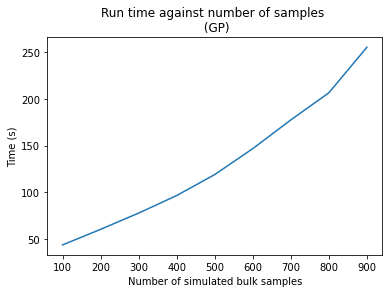

In [16]:
# Plot run-time
plt.plot(evaluation_resuts_df.n_samples.to_numpy(), evaluation_resuts_df.fit_time.to_numpy())
plt.xlabel("Number of simulated bulk samples")
plt.ylabel("Time (s)")
plt.title("Run time against number of samples \n (GP)")
plt.savefig("../results/runtime_vs_bulk-vary_n-gp.png", dpi=300)

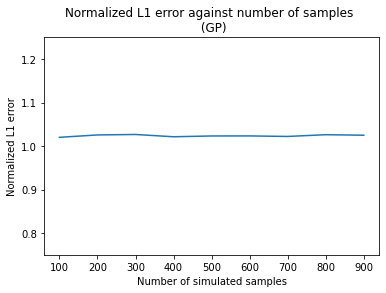

In [17]:
# Plot L1 loss
plt.plot(evaluation_resuts_df.n_samples.to_numpy(), evaluation_resuts_df.l1_error_norm.to_numpy())
plt.xlabel("Number of simulated samples")
plt.ylabel("Normalized L1 error")
plt.title("Normalized L1 error against number of samples \n (GP)")
plt.ylim(0.75,1.25)
plt.savefig("../results/NormL1_vs_bulk-vary_n-gp.png", dpi=300)